In [3]:
#+.+
import numpy as np 
import torch
import torch.nn as nn 
import torch.optim as optim
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SET-UP

In [4]:
#ISING MODEL PARAMETERS
L=40 #linear system size 
J=-1.0 #Ising interaction, not actually necessary
T=np.linspace(0.25,4.0,16) #temperatures, not actually necessary
Tc=2.26 #critical temperature, not actually necessary

#DATA
data=pkl.load(open("Ising2DFM_reSample_L40_T=All.pkl","rb"))
data=np.unpackbits(data).astype(int).reshape(-1,1600)
data[np.where(data==0)]=-1 #map 0 state to -1 (Ising variable takes +/-1 values), not actually necessary (but useful if one wants to conduct further studies involving the Hamiltonian)
#print("data ", data)
#print(data.shape)

#LABELS 
labels=pkl.load(open("Ising2DFM_reSample_L40_T=All_labels.pkl","rb")) #1: ordered, 0: disordered
#print("labels ", labels)

#DIVIDE DATA INTO ORDERED, CRITICAL, DISORDERED
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]  
#print(Y_ordered)
X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]
#print(Y_critical)
X_disordered=data[100000:,:]
Y_disordered=labels[100000:]
#print(Y_disordered)
del data,labels #delete original arrays

#TRAINING AND TEST DATA SETS ON ORDERED & DISORDERED STATES
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.8,test_size=0.2) #train on 80% of this data
X=np.concatenate((X_critical,X)) #retrieve full data set, not really necessary
Y=np.concatenate((Y_critical,Y)) #retrieve full labels set, not really necessary

MODEL

In [5]:
#IDEALIZED MODEL: L2 regularization with lambda=3e-5, max_iter=375, no seeding
def model():
    
    train_accuracies=[]
    test_accuracies=[]
    crit_accuracies=[]

    #DEFINE LOG REG MODEL 
    class LogReg(nn.Module):
        def __init__(self,input_dim): 
            super(LogReg,self).__init__()
            self.linear=nn.Linear(input_dim,1) #outputs value of dim. 1
            
        def forward(self,x): #passes input through linear layer and apply sigmoid activation function to produce output
            return torch.sigmoid(self.linear(x)) #sigmoid function
            
    def l2_loss(model,criterion,inputs,labels,lambd=3e-5):
        outputs=model(inputs)
        loss=criterion(outputs,labels.view(-1,1))
        l2_reg=torch.tensor(0.)
        for param in model.parameters():
            l2_reg+=torch.norm(param)
        loss+=lambd*l2_reg
        return loss
                    
    #LOSS FUNCTION AND OPTIMIZER   
    model=LogReg(input_dim=X_train.shape[1]) #instance of LogReg class created
    criterion=nn.BCELoss() #Binary Cross Entropy Loss used as loss function
    optimizer=optim.LBFGS(model.parameters(),lr=0.01,max_iter=375)

    inputs=torch.tensor(X_train,dtype=torch.float32) #convert to PyTorch tensors
    labels=torch.tensor(Y_train,dtype=torch.float32)

    #L-BFGS OPTIMIZATION CLOSURE
    def closure():
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=l2_loss(model,criterion,inputs,labels)
        loss.backward()
        return loss

    #OPTIMIZATION
    optimizer.step(closure)
                
    #EVALUATION ON TRAINING DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_train,dtype=torch.float32)
        labels=torch.tensor(Y_train,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on training data: {accuracy: .4%}")
        train_accuracies.append(accuracy) 
            
    #EVALUATION ON TEST DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_test,dtype=torch.float32)
        labels=torch.tensor(Y_test,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on test data: {accuracy: .4%}")
        test_accuracies.append(accuracy)
            
    #EVALUATION ON CRITICAL DATA
    with torch.no_grad(): 
        inputs=torch.tensor(X_critical,dtype=torch.float32)
        labels=torch.tensor(Y_critical,dtype=torch.float32)
        outputs=model(inputs) #get model predictions
        predicted=(outputs>=0.5).float() #if >=0.5, prediction class 1, otherwise 0
        accuracy=(predicted==labels.view(-1,1)).sum().item()/len(labels)
        print(f"Accuracy on critical data: {accuracy: .4%}\n")
        crit_accuracies.append(accuracy)
    
    return train_accuracies,test_accuracies,crit_accuracies 

In [20]:
train=[]
test=[]
crit=[]
for i in range(10): 
    print("\nRun ", (i+1))
    train_accuracies,test_accuracies,crit_accuracies=model()
    train.append(train_accuracies)
    test.append(test_accuracies)
    crit.append(crit_accuracies)


Run  1
Accuracy on training data:  70.9154%
Accuracy on test data:  68.2962%
Accuracy on critical data:  63.4333%


Run  2
Accuracy on training data:  71.0663%
Accuracy on test data:  68.6269%
Accuracy on critical data:  63.2733%


Run  3
Accuracy on training data:  71.0817%
Accuracy on test data:  68.5000%
Accuracy on critical data:  63.2867%


Run  4
Accuracy on training data:  71.1010%
Accuracy on test data:  68.4500%
Accuracy on critical data:  63.2900%


Run  5
Accuracy on training data:  71.0683%
Accuracy on test data:  68.3692%
Accuracy on critical data:  63.3533%


Run  6
Accuracy on training data:  71.1663%
Accuracy on test data:  68.6038%
Accuracy on critical data:  63.2300%


Run  7
Accuracy on training data:  71.0702%
Accuracy on test data:  68.4231%
Accuracy on critical data:  63.3533%


Run  8
Accuracy on training data:  71.1769%
Accuracy on test data:  68.4462%
Accuracy on critical data:  63.1733%


Run  9
Accuracy on training data:  71.1490%
Accuracy on test data:  68.

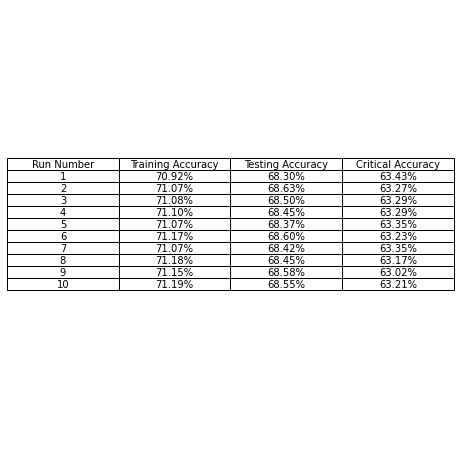

In [28]:
columns=["Run Number","Training Accuracy","Testing Accuracy","Critical Accuracy"]
row_labels=["1","2","3","4","5","6","7","8","9","10"]

train1=[f"{float(val[0])*100:.2f}%" for val in train]
test1=[f"{float(val1[0])*100:.2f}%" for val1 in test]
crit1=[f"{float(val2[0])*100:.2f}%" for val2 in crit]

fig,ax=plt.subplots(figsize=(8,8))
ax.axis('tight')
ax.axis('off')
table_data=[columns]+list(zip(row_labels,train1,test1,crit1))
ax.table(cellText=table_data,loc='center',cellLoc='center')
plt.show()

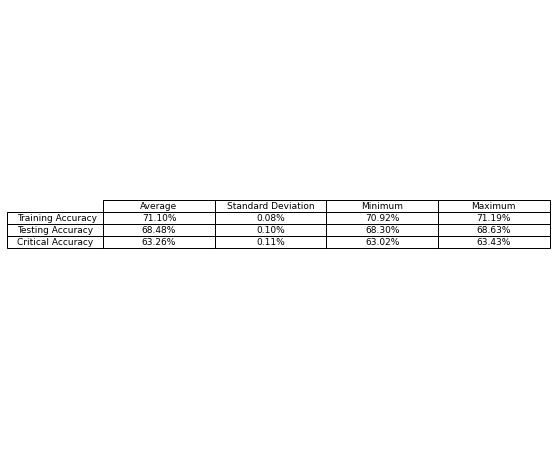

In [49]:
row_labels=["Training Accuracy","Testing Accuracy","Critical Accuracy"]
columns=["Average","Standard Deviation","Minimum","Maximum"]

train_float=[float(val3[0]) for val3 in train]
test_float=[float(val4[0]) for val4 in test]
crit_float=[float(val5[0]) for val5 in crit]

avg_train=np.mean(train_float)
std_train=np.std(train_float)
min_train=np.min(train_float)
max_train=np.max(train_float)

avg_test=np.mean(test_float)
std_test=np.std(test_float)
min_test=np.min(test_float)
max_test=np.max(test_float)

avg_crit=np.mean(crit_float)
std_crit=np.std(crit_float)
min_crit=np.min(crit_float)
max_crit=np.max(crit_float)

avgs=[avg_train,avg_test,avg_crit]
stds=[std_train,std_test,std_crit]
mins=[min_train,min_test,min_crit]
maxs=[max_train,max_test,max_crit]

avg1=[f"{float(a)*100:.2f}%" for a in avgs]
std1=[f"{float(s)*100:.2f}%" for s in stds]
min1=[f"{float(mn)*100:.2f}%" for mn in mins]
max1=[f"{float(ma)*100:.2f}%" for ma in maxs]

table_data=[avg1,std1,min1,max1]

fig,ax=plt.subplots(figsize=(8,8))
ax.axis('tight')
ax.axis('off')
table_data=list(zip(avg1,std1,min1,max1))
ax.table(cellText=table_data,loc='center',cellLoc='center',rowLabels=row_labels,colLabels=columns)
plt.show()